In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# AICellFate model with image data

In [1]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# load all confusion matrices

conf_matrix_cellfate_seed42 = np.sum((np.load('all_confusion_matrices_cellfate_6.npy'), np.load('all_confusion_matrices_cellfate_10.npy')), axis=0)
conf_matrix_cellfate_seed43 = np.sum((np.load('all_confusion_matrices_cellfate_seed43_3.npy'), np.load('all_confusion_matrices_cellfate_seed43_6.npy'), np.load('all_confusion_matrices_cellfate_seed43_10.npy')), axis=0)
conf_matrix_cellfate_seed44 = np.sum((np.load('all_confusion_matrices_cellfate_seed44_4.npy'), np.load('all_confusion_matrices_cellfate_seed44_10.npy')), axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [50]:
conf_matrix_cellfate[0,0][0,1]

0.34234234234234234

In [51]:
# calculate precisions

precision_cellfate = np.zeros((11, 3))
accuracy_cellfate = np.zeros((11, 3))
false_positives_cellfate = np.zeros((11, 3))
false_negatives_cellfate = np.zeros((11, 3))

for tp in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, tp]
        precision_cellfate[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [59]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

Plotting results of our model

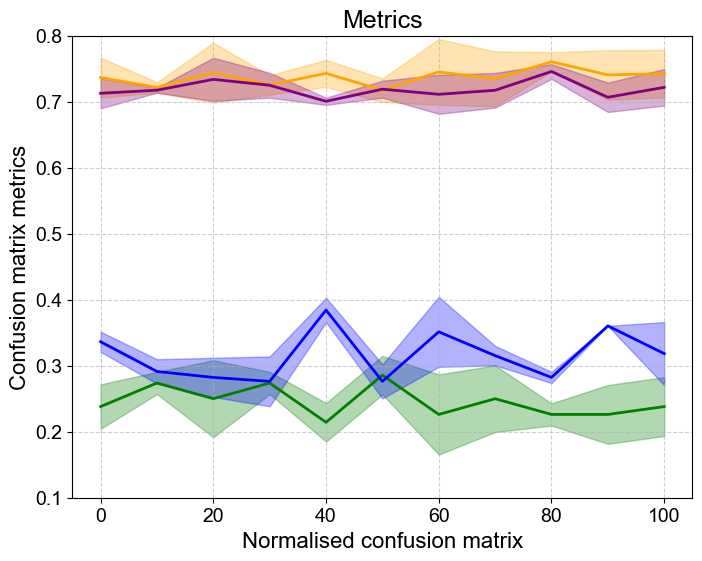

In [60]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(time_points, mean_precisions, color='orange', linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(time_points, mean_accuracies, color='purple', linewidth=2)
plt.fill_between(time_points, mean_accuracies - std_accuracies, 
                 mean_accuracies + std_accuracies, color='purple', alpha=0.3)

# False Positives (green)
plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
plt.fill_between(time_points, mean_false_positives - std_false_positives,
                 mean_false_positives + std_false_positives, color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
                    mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Normalised confusion matrix", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# MLP model with tabular data

In [ ]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [2]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [3]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

train_tracks_features = train_tracks[:, :, 4:17] 
test_tracks_features = test_tracks[:, :, 4:17]

In [8]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)
        
        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data

In [9]:
train_tracks_norm = normalize_cell_time(train_tracks_features)
test_tracks_norm = normalize_cell_time(test_tracks_features)

In [27]:
conf_matrix_tabular = np.zeros((3, 11, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

for seed in [42, 43, 44]:
    for i in range(train_tracks_norm.shape[1]): #tabular_train.shape[1]
        frame = i
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)
        np.random.seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_norm[:,frame,:].shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_norm[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_norm[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels[~(np.all(train_tracks_norm == 0, axis=(1, 2)))]))
        threshold = 0.5
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        conf_matrix_tabular[seed-42, i] = conf_matrix_normalized

        # all_confusion_matrices[i] = conf_matrix_normalized

        # precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
        # mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        # print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

        # precisions[i] = precision
        # mean_diagonals[i] = mean_diagonal


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6777 - loss: 0.7542 - val_accuracy: 0.8043 - val_loss: 0.5931
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.7059 - val_accuracy: 0.8188 - val_loss: 0.6393
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.5235 - loss: 0.7127 - val_accuracy: 0.5290 - val_loss: 0.6843
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.6937 - val_accuracy: 0.5072 - val_loss: 0.6876
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.5121 - loss: 0.6792 - val_accuracy: 0.4638 - val_loss: 0.6797
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.5070 - loss: 0.6980 - val_accuracy: 0.4928 - val_loss: 0.6750
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.5357 - loss: 0.6572 - val_accuracy: 0.4928 - val_loss: 0.6700
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.5343 - loss: 0.6672 - val_accuracy: 0.5217 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.7621 - val_accuracy: 0.8406 - val_loss: 0.5748
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.7042 - val_accuracy: 0.8478 - val_loss: 0.6164
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5732 - loss: 0.7201 - val_accuracy: 0.5942 - val_loss: 0.6813
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.5113 - loss: 0.7011 - val_accuracy: 0.4493 - val_loss: 0.6988
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.5064 - loss: 0.6778 - val_accuracy: 0.4203 - val_loss: 0.7034
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.5187 - loss: 0.6883 - val_accuracy: 0.4710 - val_loss: 0.6892
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.5451 - loss: 0.6602 - val_accuracy: 0.5072 - val_loss: 0.6858
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5391 - loss: 0.6772 - val_accuracy: 0.5290 -

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6857 - loss: 0.7701 - val_accuracy: 0.8623 - val_loss: 0.5417
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6348 - loss: 0.7036 - val_accuracy: 0.8623 - val_loss: 0.5888
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.5570 - loss: 0.7205 - val_accuracy: 0.6594 - val_loss: 0.6566
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5512 - loss: 0.6911 - val_accuracy: 0.5652 - val_loss: 0.6685
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5497 - loss: 0.6725 - val_accuracy: 0.5725 - val_loss: 0.6570
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5489 - loss: 0.6831 - val_accuracy: 0.5942 - val_loss: 0.6433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5871 - loss: 0.6348 - val_accuracy: 0.5580 - val_loss: 0.6461
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5346 - loss: 0.6659 - val_accuracy: 0.57

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 0.7681 - val_accuracy: 0.8623 - val_loss: 0.5357
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.7035 - val_accuracy: 0.8551 - val_loss: 0.5954
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5889 - loss: 0.7111 - val_accuracy: 0.6087 - val_loss: 0.6610
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5563 - loss: 0.6876 - val_accuracy: 0.5362 - val_loss: 0.6706
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5147 - loss: 0.6733 - val_accuracy: 0.5290 - val_loss: 0.6687
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.5649 - loss: 0.6762 - val_accuracy: 0.5652 - val_loss: 0.6510
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.5921 - loss: 0.6500 - val_accuracy: 0.5290 - val_loss: 0.6613
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5741 - loss: 0.6515 - val_accuracy: 0.5290

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.7617 - val_accuracy: 0.8623 - val_loss: 0.5276
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.7056 - val_accuracy: 0.8188 - val_loss: 0.6017
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5874 - loss: 0.7145 - val_accuracy: 0.6304 - val_loss: 0.6562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5489 - loss: 0.6916 - val_accuracy: 0.5652 - val_loss: 0.6619
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.5669 - loss: 0.6675 - val_accuracy: 0.5797 - val_loss: 0.6657
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5641 - loss: 0.6707 - val_accuracy: 0.5580 - val_loss: 0.6633
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.5762 - loss: 0.6275 - val_accuracy: 0.5797 - val_loss: 0.6544
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5694 - loss: 0.6484 - val_accuracy: 0.6087

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6981 - loss: 0.7527 - val_accuracy: 0.8623 - val_loss: 0.5340
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7045 - val_accuracy: 0.8478 - val_loss: 0.5831
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5710 - loss: 0.7140 - val_accuracy: 0.6884 - val_loss: 0.6302
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.5523 - loss: 0.6935 - val_accuracy: 0.6884 - val_loss: 0.6402
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5520 - loss: 0.6726 - val_accuracy: 0.6232 - val_loss: 0.6487
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.5667 - loss: 0.6733 - val_accuracy: 0.6159 - val_loss: 0.6360
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5883 - loss: 0.6349 - val_accuracy: 0.6087 - val_loss: 0.6432
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.5560 - loss: 0.6585 - val_accuracy: 0.6087 -

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6959 - loss: 0.7580 - val_accuracy: 0.8696 - val_loss: 0.5371
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.7025 - val_accuracy: 0.8696 - val_loss: 0.5694
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5986 - loss: 0.7078 - val_accuracy: 0.7101 - val_loss: 0.6166
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5911 - loss: 0.6804 - val_accuracy: 0.6377 - val_loss: 0.6265
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5726 - loss: 0.6709 - val_accuracy: 0.5870 - val_loss: 0.6228
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.5905 - loss: 0.6584 - val_accuracy: 0.5870 - val_loss: 0.6076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5821 - loss: 0.6286 - val_accuracy: 0.6014 - val_loss: 0.6062
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.6028 - loss: 0.6360 - val_accuracy: 0.6159 -

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6845 - loss: 0.7527 - val_accuracy: 0.8696 - val_loss: 0.5113
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.7010 - val_accuracy: 0.8623 - val_loss: 0.5679
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.6050 - loss: 0.7119 - val_accuracy: 0.6812 - val_loss: 0.6292
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.5356 - loss: 0.6870 - val_accuracy: 0.6014 - val_loss: 0.6468
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5347 - loss: 0.6829 - val_accuracy: 0.5797 - val_loss: 0.6521
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5486 - loss: 0.6831 - val_accuracy: 0.5725 - val_loss: 0.6422
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5760 - loss: 0.6458 - val_accuracy: 0.5725 - val_loss: 0.6426
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5811 - loss: 0.6452 - val_accuracy: 0.6014

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6925 - loss: 0.7463 - val_accuracy: 0.8623 - val_loss: 0.5436
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6524 - loss: 0.6977 - val_accuracy: 0.8478 - val_loss: 0.6089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.6101 - loss: 0.7048 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5578 - loss: 0.6951 - val_accuracy: 0.5072 - val_loss: 0.6523
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5378 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.6517
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5586 - loss: 0.6874 - val_accuracy: 0.5507 - val_loss: 0.6355
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5570 - loss: 0.6478 - val_accuracy: 0.5942 - val_loss: 0.6371
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5591 - loss: 0.6556 - val_accuracy: 0.59

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7012 - loss: 0.7499 - val_accuracy: 0.8623 - val_loss: 0.5660
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.7068 - val_accuracy: 0.7826 - val_loss: 0.6303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.5641 - loss: 0.7148 - val_accuracy: 0.5072 - val_loss: 0.6892
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.5295 - loss: 0.7008 - val_accuracy: 0.4565 - val_loss: 0.6946
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5438 - loss: 0.6869 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.5523 - loss: 0.6843 - val_accuracy: 0.5290 - val_loss: 0.6692
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5654 - loss: 0.6543 - val_accuracy: 0.5435 - val_loss: 0.6621
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5706 - loss: 0.6570 - val_accuracy: 0.5652

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7119 - loss: 0.7453 - val_accuracy: 0.8696 - val_loss: 0.4989
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7011 - val_accuracy: 0.8696 - val_loss: 0.5986
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5983 - loss: 0.7137 - val_accuracy: 0.6304 - val_loss: 0.6604
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5342 - loss: 0.6981 - val_accuracy: 0.5580 - val_loss: 0.6744
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5542 - loss: 0.6956 - val_accuracy: 0.5145 - val_loss: 0.6774
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5679 - loss: 0.6848 - val_accuracy: 0.5725 - val_loss: 0.6637
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.6013 - loss: 0.6571 - val_accuracy: 0.5870 - val_loss: 0.6502
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5656 - loss: 0.6621 - val_accuracy: 0.5797

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5238 - loss: 0.7223 - val_accuracy: 0.2464 - val_loss: 0.8351
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5633 - loss: 0.6725 - val_accuracy: 0.3406 - val_loss: 0.8008
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5375 - loss: 0.6721 - val_accuracy: 0.4130 - val_loss: 0.7600
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5872 - loss: 0.6734 - val_accuracy: 0.4928 - val_loss: 0.7242
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6305 - loss: 0.6628 - val_accuracy: 0.5217 - val_loss: 0.7056
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6606 - loss: 0.6572 - val_accuracy: 0.5507 - val_loss: 0.6935
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.6535 - loss: 0.6464 - val_accuracy: 0.6014 - val_loss: 0.6770
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.6883 - loss: 0.6475 - val_accuracy: 0.58

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_13          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5154 - loss: 0.7130 - val_accuracy: 0.2754 - val_loss: 0.7858
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5512 - loss: 0.6776 - val_accuracy: 0.3696 - val_loss: 0.7322
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.5932 - loss: 0.6710 - val_accuracy: 0.4638 - val_loss: 0.7289
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5986 - loss: 0.6654 - val_accuracy: 0.4928 - val_loss: 0.7114
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6370 - loss: 0.6591 - val_accuracy: 0.5217 - val_loss: 0.6972
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.6834 - loss: 0.6587 - val_accuracy: 0.5580 - val_loss: 0.6846
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.6762 - loss: 0.6438 - val_accuracy: 0.5870 - val_loss: 0.6736
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6975 - loss: 0.6322 - val_accuracy: 0.5942

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_14          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5148 - loss: 0.7143 - val_accuracy: 0.2536 - val_loss: 0.8186
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.6751 - val_accuracy: 0.3478 - val_loss: 0.7696
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6218 - loss: 0.6644 - val_accuracy: 0.4638 - val_loss: 0.7331
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6393 - loss: 0.6498 - val_accuracy: 0.5362 - val_loss: 0.7104
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6792 - loss: 0.6501 - val_accuracy: 0.5797 - val_loss: 0.6924
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.7210 - loss: 0.6422 - val_accuracy: 0.6232 - val_loss: 0.6680
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6755 - loss: 0.6253 - val_accuracy: 0.6667 - val_loss: 0.6470
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.7251 - loss: 0.6318 - val_accuracy: 0.6232

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_15          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4966 - loss: 0.7136 - val_accuracy: 0.3116 - val_loss: 0.7859
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5541 - loss: 0.6724 - val_accuracy: 0.3406 - val_loss: 0.7668
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.5917 - loss: 0.6691 - val_accuracy: 0.4638 - val_loss: 0.7340
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.6191 - loss: 0.6534 - val_accuracy: 0.5435 - val_loss: 0.7088
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.6628 - loss: 0.6472 - val_accuracy: 0.5290 - val_loss: 0.6954
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7115 - loss: 0.6446 - val_accuracy: 0.5725 - val_loss: 0.6756
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6773 - loss: 0.6282 - val_accuracy: 0.6159 - val_loss: 0.6571
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7160 - loss: 0.6456 - val_accuracy: 0.6159

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_16          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5055 - loss: 0.7136 - val_accuracy: 0.2681 - val_loss: 0.8081
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5921 - loss: 0.6745 - val_accuracy: 0.3478 - val_loss: 0.7861
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.5985 - loss: 0.6750 - val_accuracy: 0.4565 - val_loss: 0.7381
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6372 - loss: 0.6486 - val_accuracy: 0.5290 - val_loss: 0.7073
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.6725 - loss: 0.6522 - val_accuracy: 0.5507 - val_loss: 0.6867
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6931 - loss: 0.6401 - val_accuracy: 0.6159 - val_loss: 0.6539
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6720 - loss: 0.6318 - val_accuracy: 0.6377 - val_loss: 0.6267
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6866 - loss: 0.6360 - val_accuracy: 0.63

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_17          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5205 - loss: 0.7095 - val_accuracy: 0.3261 - val_loss: 0.7808
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.5774 - loss: 0.6732 - val_accuracy: 0.4420 - val_loss: 0.7347
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5952 - loss: 0.6640 - val_accuracy: 0.4928 - val_loss: 0.7198
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.6584 - loss: 0.6486 - val_accuracy: 0.5290 - val_loss: 0.6954
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.6528 - val_accuracy: 0.5942 - val_loss: 0.6756
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6816 - loss: 0.6462 - val_accuracy: 0.6594 - val_loss: 0.6525
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.6625 - loss: 0.6318 - val_accuracy: 0.6739 - val_loss: 0.6247
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6906 - loss: 0.6296 - val_accuracy: 0.6812 -

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_18          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5317 - loss: 0.7117 - val_accuracy: 0.3188 - val_loss: 0.7593
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5825 - loss: 0.6684 - val_accuracy: 0.4710 - val_loss: 0.7051
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6026 - loss: 0.6639 - val_accuracy: 0.5145 - val_loss: 0.6918
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6501 - loss: 0.6429 - val_accuracy: 0.5725 - val_loss: 0.6789
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.6817 - loss: 0.6440 - val_accuracy: 0.6304 - val_loss: 0.6624
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6990 - loss: 0.6366 - val_accuracy: 0.6232 - val_loss: 0.6419
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.6819 - loss: 0.6286 - val_accuracy: 0.6522 - val_loss: 0.6198
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.7209 - loss: 0.6139 - val_accuracy: 0.6594

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_19          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5295 - loss: 0.7019 - val_accuracy: 0.2754 - val_loss: 0.8197
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5627 - loss: 0.6767 - val_accuracy: 0.4130 - val_loss: 0.7420
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5956 - loss: 0.6774 - val_accuracy: 0.4855 - val_loss: 0.7156
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.6360 - loss: 0.6424 - val_accuracy: 0.5145 - val_loss: 0.6914
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6659 - loss: 0.6488 - val_accuracy: 0.5942 - val_loss: 0.6650
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7034 - loss: 0.6336 - val_accuracy: 0.6087 - val_loss: 0.6469
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.6697 - loss: 0.6273 - val_accuracy: 0.6232 - val_loss: 0.6200
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6976 - loss: 0.6159 - val_accuracy: 0.6377

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_20          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5282 - loss: 0.7068 - val_accuracy: 0.3478 - val_loss: 0.7488
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5955 - loss: 0.6732 - val_accuracy: 0.4855 - val_loss: 0.6977
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.6068 - loss: 0.6713 - val_accuracy: 0.5072 - val_loss: 0.6969
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6399 - loss: 0.6552 - val_accuracy: 0.5725 - val_loss: 0.6894
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.6540 - loss: 0.6511 - val_accuracy: 0.6087 - val_loss: 0.6687
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.6686 - loss: 0.6493 - val_accuracy: 0.6232 - val_loss: 0.6529
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6380 - loss: 0.6356 - val_accuracy: 0.6377 - val_loss: 0.6285
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6767 - loss: 0.6310 - val_accuracy: 0.6377

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_21          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5174 - loss: 0.7058 - val_accuracy: 0.2464 - val_loss: 0.8155
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.6718 - val_accuracy: 0.3333 - val_loss: 0.7633
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.5862 - loss: 0.6746 - val_accuracy: 0.4275 - val_loss: 0.7437
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6093 - loss: 0.6549 - val_accuracy: 0.4493 - val_loss: 0.7146
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6481 - loss: 0.6571 - val_accuracy: 0.5000 - val_loss: 0.6902
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6890 - loss: 0.6519 - val_accuracy: 0.5217 - val_loss: 0.6712
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.6399 - loss: 0.6335 - val_accuracy: 0.5652 - val_loss: 0.6433
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6936 - loss: 0.6268 - val_accuracy: 0.5870 -

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_22          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5153 - loss: 0.7006 - val_accuracy: 0.3478 - val_loss: 0.7709
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5609 - loss: 0.6758 - val_accuracy: 0.4130 - val_loss: 0.7307
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5829 - loss: 0.6748 - val_accuracy: 0.5000 - val_loss: 0.7020
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 0.6576 - val_accuracy: 0.5435 - val_loss: 0.6873
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6327 - loss: 0.6564 - val_accuracy: 0.5652 - val_loss: 0.6743
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.6679 - loss: 0.6488 - val_accuracy: 0.5725 - val_loss: 0.6567
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6292 - loss: 0.6400 - val_accuracy: 0.6014 - val_loss: 0.6341
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6703 - loss: 0.6208 - val_accuracy: 0.6014 -

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_23          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7059 - loss: 0.8835 - val_accuracy: 0.7319 - val_loss: 0.5684
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5495 - loss: 0.7439 - val_accuracy: 0.3551 - val_loss: 0.7516
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.5728 - loss: 0.6938 - val_accuracy: 0.3333 - val_loss: 0.7509
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5472 - loss: 0.6973 - val_accuracy: 0.3696 - val_loss: 0.7297
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5415 - loss: 0.6684 - val_accuracy: 0.3986 - val_loss: 0.7139
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.5528 - loss: 0.6908 - val_accuracy: 0.4493 - val_loss: 0.6854
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.5498 - loss: 0.6906 - val_accuracy: 0.4420 - val_loss: 0.6760
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.5807 - loss: 0.6633 - val_accuracy: 0.4638

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_24          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6904 - loss: 0.8866 - val_accuracy: 0.8261 - val_loss: 0.5403
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5752 - loss: 0.7529 - val_accuracy: 0.3188 - val_loss: 0.7483
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.5657 - loss: 0.6947 - val_accuracy: 0.2681 - val_loss: 0.7524
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.5340 - loss: 0.6999 - val_accuracy: 0.3188 - val_loss: 0.7364
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5387 - loss: 0.6915 - val_accuracy: 0.3696 - val_loss: 0.7191
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5209 - loss: 0.7134 - val_accuracy: 0.4275 - val_loss: 0.7011
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.5364 - loss: 0.6969 - val_accuracy: 0.4855 - val_loss: 0.6833
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.5867 - loss: 0.6644 - val_accuracy: 0.5217

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_25          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7043 - loss: 0.8775 - val_accuracy: 0.7536 - val_loss: 0.5440
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6055 - loss: 0.7341 - val_accuracy: 0.3551 - val_loss: 0.7288
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5618 - loss: 0.6900 - val_accuracy: 0.3623 - val_loss: 0.7311
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5458 - loss: 0.6927 - val_accuracy: 0.4058 - val_loss: 0.7116
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5735 - loss: 0.6669 - val_accuracy: 0.4565 - val_loss: 0.6922
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5652 - loss: 0.6918 - val_accuracy: 0.5290 - val_loss: 0.6613
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5776 - loss: 0.6809 - val_accuracy: 0.5217 - val_loss: 0.6547
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6185 - loss: 0.6446 - val_accuracy: 0.5362

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_26          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6976 - loss: 0.8955 - val_accuracy: 0.7609 - val_loss: 0.5565
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 0.7426 - val_accuracy: 0.4638 - val_loss: 0.7086
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.5634 - loss: 0.6923 - val_accuracy: 0.4638 - val_loss: 0.7075
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5446 - loss: 0.7018 - val_accuracy: 0.4710 - val_loss: 0.6996
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5648 - loss: 0.6818 - val_accuracy: 0.4710 - val_loss: 0.6973
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5566 - loss: 0.6994 - val_accuracy: 0.4783 - val_loss: 0.6744
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5786 - loss: 0.6854 - val_accuracy: 0.5217 - val_loss: 0.6601
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5933 - loss: 0.6577 - val_accuracy: 0.5217

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_27          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6936 - loss: 0.9085 - val_accuracy: 0.8188 - val_loss: 0.5138
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5743 - loss: 0.7345 - val_accuracy: 0.5652 - val_loss: 0.6519
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5458 - loss: 0.7006 - val_accuracy: 0.4928 - val_loss: 0.6611
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5610 - loss: 0.7169 - val_accuracy: 0.4710 - val_loss: 0.6674
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5606 - loss: 0.6692 - val_accuracy: 0.5290 - val_loss: 0.6602
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5409 - loss: 0.7022 - val_accuracy: 0.5580 - val_loss: 0.6398
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5713 - loss: 0.6722 - val_accuracy: 0.5652 - val_loss: 0.6321
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5839 - loss: 0.6573 - val_accuracy: 0.5870

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_28          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6867 - loss: 0.8906 - val_accuracy: 0.8188 - val_loss: 0.5166
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 0.7413 - val_accuracy: 0.4565 - val_loss: 0.6800
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.5339 - loss: 0.6906 - val_accuracy: 0.4203 - val_loss: 0.6960
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5365 - loss: 0.7045 - val_accuracy: 0.4275 - val_loss: 0.6831
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5743 - loss: 0.6755 - val_accuracy: 0.4565 - val_loss: 0.6761
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5410 - loss: 0.7015 - val_accuracy: 0.4493 - val_loss: 0.6659
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5520 - loss: 0.6692 - val_accuracy: 0.5145 - val_loss: 0.6530
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.5854 - loss: 0.6575 - val_accuracy: 0.5217

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_29          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6971 - loss: 0.8740 - val_accuracy: 0.7391 - val_loss: 0.5574
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5861 - loss: 0.7371 - val_accuracy: 0.4203 - val_loss: 0.7003
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.5852 - loss: 0.6770 - val_accuracy: 0.3986 - val_loss: 0.6811
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.5852 - loss: 0.6725 - val_accuracy: 0.4275 - val_loss: 0.6589
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.5922 - loss: 0.6535 - val_accuracy: 0.4928 - val_loss: 0.6402
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5789 - loss: 0.6619 - val_accuracy: 0.4638 - val_loss: 0.6360
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5908 - loss: 0.6445 - val_accuracy: 0.5072 - val_loss: 0.6238
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.6321 - loss: 0.6234 - val_accuracy: 0.5652

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_30          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7003 - loss: 0.8786 - val_accuracy: 0.6739 - val_loss: 0.5902
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5937 - loss: 0.7278 - val_accuracy: 0.4855 - val_loss: 0.6930
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.5615 - loss: 0.6966 - val_accuracy: 0.4565 - val_loss: 0.6886
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5649 - loss: 0.6947 - val_accuracy: 0.4565 - val_loss: 0.6663
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5874 - loss: 0.6668 - val_accuracy: 0.4783 - val_loss: 0.6462
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.6055 - loss: 0.6728 - val_accuracy: 0.4783 - val_loss: 0.6318
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5926 - loss: 0.6685 - val_accuracy: 0.5000 - val_loss: 0.6276
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6102 - loss: 0.6271 - val_accuracy: 0.5362

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_31          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6783 - loss: 0.8773 - val_accuracy: 0.6449 - val_loss: 0.6045
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - loss: 0.7413 - val_accuracy: 0.4493 - val_loss: 0.7093
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5639 - loss: 0.7112 - val_accuracy: 0.4565 - val_loss: 0.6952
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5531 - loss: 0.7065 - val_accuracy: 0.4420 - val_loss: 0.6912
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.5474 - loss: 0.6754 - val_accuracy: 0.4710 - val_loss: 0.6658
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5849 - loss: 0.6909 - val_accuracy: 0.4928 - val_loss: 0.6433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5762 - loss: 0.6879 - val_accuracy: 0.5217 - val_loss: 0.6337
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.6044 - loss: 0.6558 - val_accuracy: 0.5217

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_32          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6809 - loss: 0.8739 - val_accuracy: 0.5725 - val_loss: 0.6494
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.5782 - loss: 0.7549 - val_accuracy: 0.2971 - val_loss: 0.7760
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.5319 - loss: 0.7153 - val_accuracy: 0.3406 - val_loss: 0.7452
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5343 - loss: 0.7099 - val_accuracy: 0.3841 - val_loss: 0.7112
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.5465 - loss: 0.6941 - val_accuracy: 0.4348 - val_loss: 0.6872
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5504 - loss: 0.7037 - val_accuracy: 0.4783 - val_loss: 0.6701
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5504 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6572
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.5887 - loss: 0.6613 - val_accuracy: 0.50

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_33          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6871 - loss: 0.8747 - val_accuracy: 0.5145 - val_loss: 0.6788
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.5746 - loss: 0.7454 - val_accuracy: 0.2971 - val_loss: 0.7521
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.5197 - loss: 0.7213 - val_accuracy: 0.3043 - val_loss: 0.7362
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5246 - loss: 0.7102 - val_accuracy: 0.3261 - val_loss: 0.7211
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.6939 - val_accuracy: 0.4203 - val_loss: 0.6916
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5443 - loss: 0.7003 - val_accuracy: 0.4493 - val_loss: 0.6792
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.5418 - loss: 0.7064 - val_accuracy: 0.4928 - val_loss: 0.6741
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5818 - loss: 0.6738 - val_accuracy: 0.5217

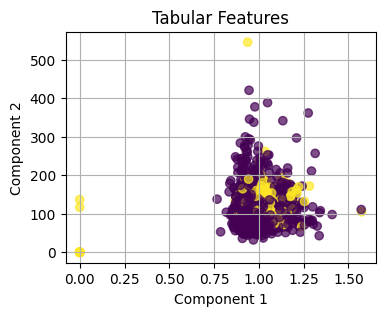

In [32]:
plt.figure(figsize=(4, 3))
plt.scatter(train_tracks_norm[:, 0, 0], train_tracks_norm[:, 0, -2], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('Tabular Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

In [37]:
# calculate precisions

precision_tabular = np.zeros((11, 3))
accuracy_tabular = np.zeros((11, 3))
false_positives_tabular = np.zeros((11, 3))
false_negatives_tabular = np.zeros((11, 3))

for tp in range(conf_matrix_tabular.shape[1]):
    for seed in range(conf_matrix_tabular.shape[0]):
        conf_matrix = conf_matrix_tabular[seed, tp]
        precision_tabular[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_tabular[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_tabular[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_tabular[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [38]:
mean_precisions = np.mean(precision_tabular, axis=1)
std_precisions = np.std(precision_tabular, axis=1)

mean_accuracies = np.mean(accuracy_tabular, axis=1)
std_accuracies = np.std(accuracy_tabular, axis=1)

mean_false_positives = np.mean(false_positives_tabular, axis=1)
std_false_positives = np.std(false_positives_tabular, axis=1)

mean_false_negatives = np.mean(false_negatives_tabular, axis=1)
std_false_negatives = np.std(false_negatives_tabular, axis=1)

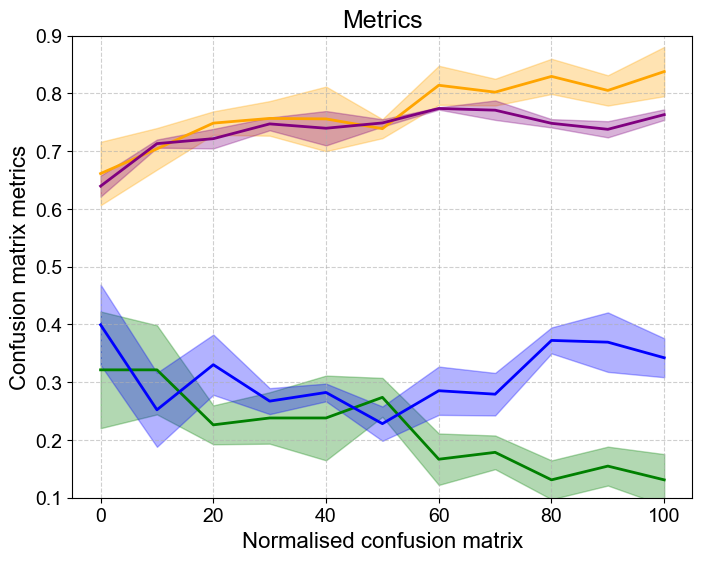

In [40]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(time_points, mean_precisions, color='orange', linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(time_points, mean_accuracies, color='purple', linewidth=2)
plt.fill_between(time_points, mean_accuracies - std_accuracies, 
                 mean_accuracies + std_accuracies, color='purple', alpha=0.3)

# False Positives (green)
plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
plt.fill_between(time_points, mean_false_positives - std_false_positives,
                 mean_false_positives + std_false_positives, color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
                    mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Normalised confusion matrix", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.9)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()